# Study of ring systems in the dataset

One of the ideas is to study the rings present in our dataset. We had some trouble with the resulting SMILES but it could be solved using the *Chemical Identifier Resolver*, from the CADD group of NCI. To know more about the online service check it out [here](https://cactus.nci.nih.gov/chemical/structure), but it basically returns a plain text request using a simple HTTP endpoint associated to the conversion format.

## Importing packages/libraries

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = (400, 300)
IPythonConsole.drawOptions.addAtomIndices = False
import pandas as pd
import numpy as np
import session_info

## Importing the data

In [2]:
# Importing the dataset
drugs_db_route_merged = pd.read_csv('../data/approved_drugs_final_2022.csv')

# Get a list of all the SMILES
drugs_smiles = list(drugs_db_route_merged.SMILES)

## Definying the extraction functions

In [3]:
# Definying a function to get all the rings
def get_ring_atoms(mol, includeSpiro=False) -> list:
    """
    Return the atoms of all the rings present in the structure
    Can be used to retrieve the ring SMILES for ex.
    """
    ri = mol.GetRingInfo()
    systems = []
    
    # Function to get the atom index of rings present in the molecule
    for ring in ri.AtomRings():
        ringAts = set(ring)
        nSystems = []
        for system in systems:
            nInCommon = len(ringAts.intersection(system))
            if nInCommon and (includeSpiro or nInCommon>1):
                ringAts = ringAts.union(system)
            else:
                nSystems.append(system)
        nSystems.append(ringAts)
        systems = nSystems
    
    # This is a list of lists, maybe you'll need to flatten it for further analysis
    return [list(ring_idx) for ring_idx in systems] 

# Definying a function to get the ring SMILES of a structure
def get_substructure_smiles(smile) -> list:
    """
    Return all the SMILES substructure from the parent molecule
    """
    #transforming the entire structure from SMILES to mol
    mol = Chem.MolFromSmiles(smile)
    substructure_smiles = []

    for ring in get_ring_atoms(mol):
        substructure_smiles.append(Chem.MolFragmentToSmiles(mol, ring, canonical=True))
    return substructure_smiles

## SMILES of ring systems

In [4]:
rings_on_smiles = []
for drug in drugs_smiles:
    rings_on_smiles.append(get_substructure_smiles(drug))

# We need to flatten the list of rings' smiles because it is a list of list
# I found this solution on STCKOVFLW using numpy
rings_on_smiles = list(np.concatenate(rings_on_smiles))

/home/gustavo/miniconda3/envs/teachopencadd/lib/python3.8/site-packages/rdkit/Chem/Draw/IPythonConsole.py:241: UserWarning: Truncating the list of molecules to be displayed to 30. Change the maxMols value to display more.
  warnings.warn(


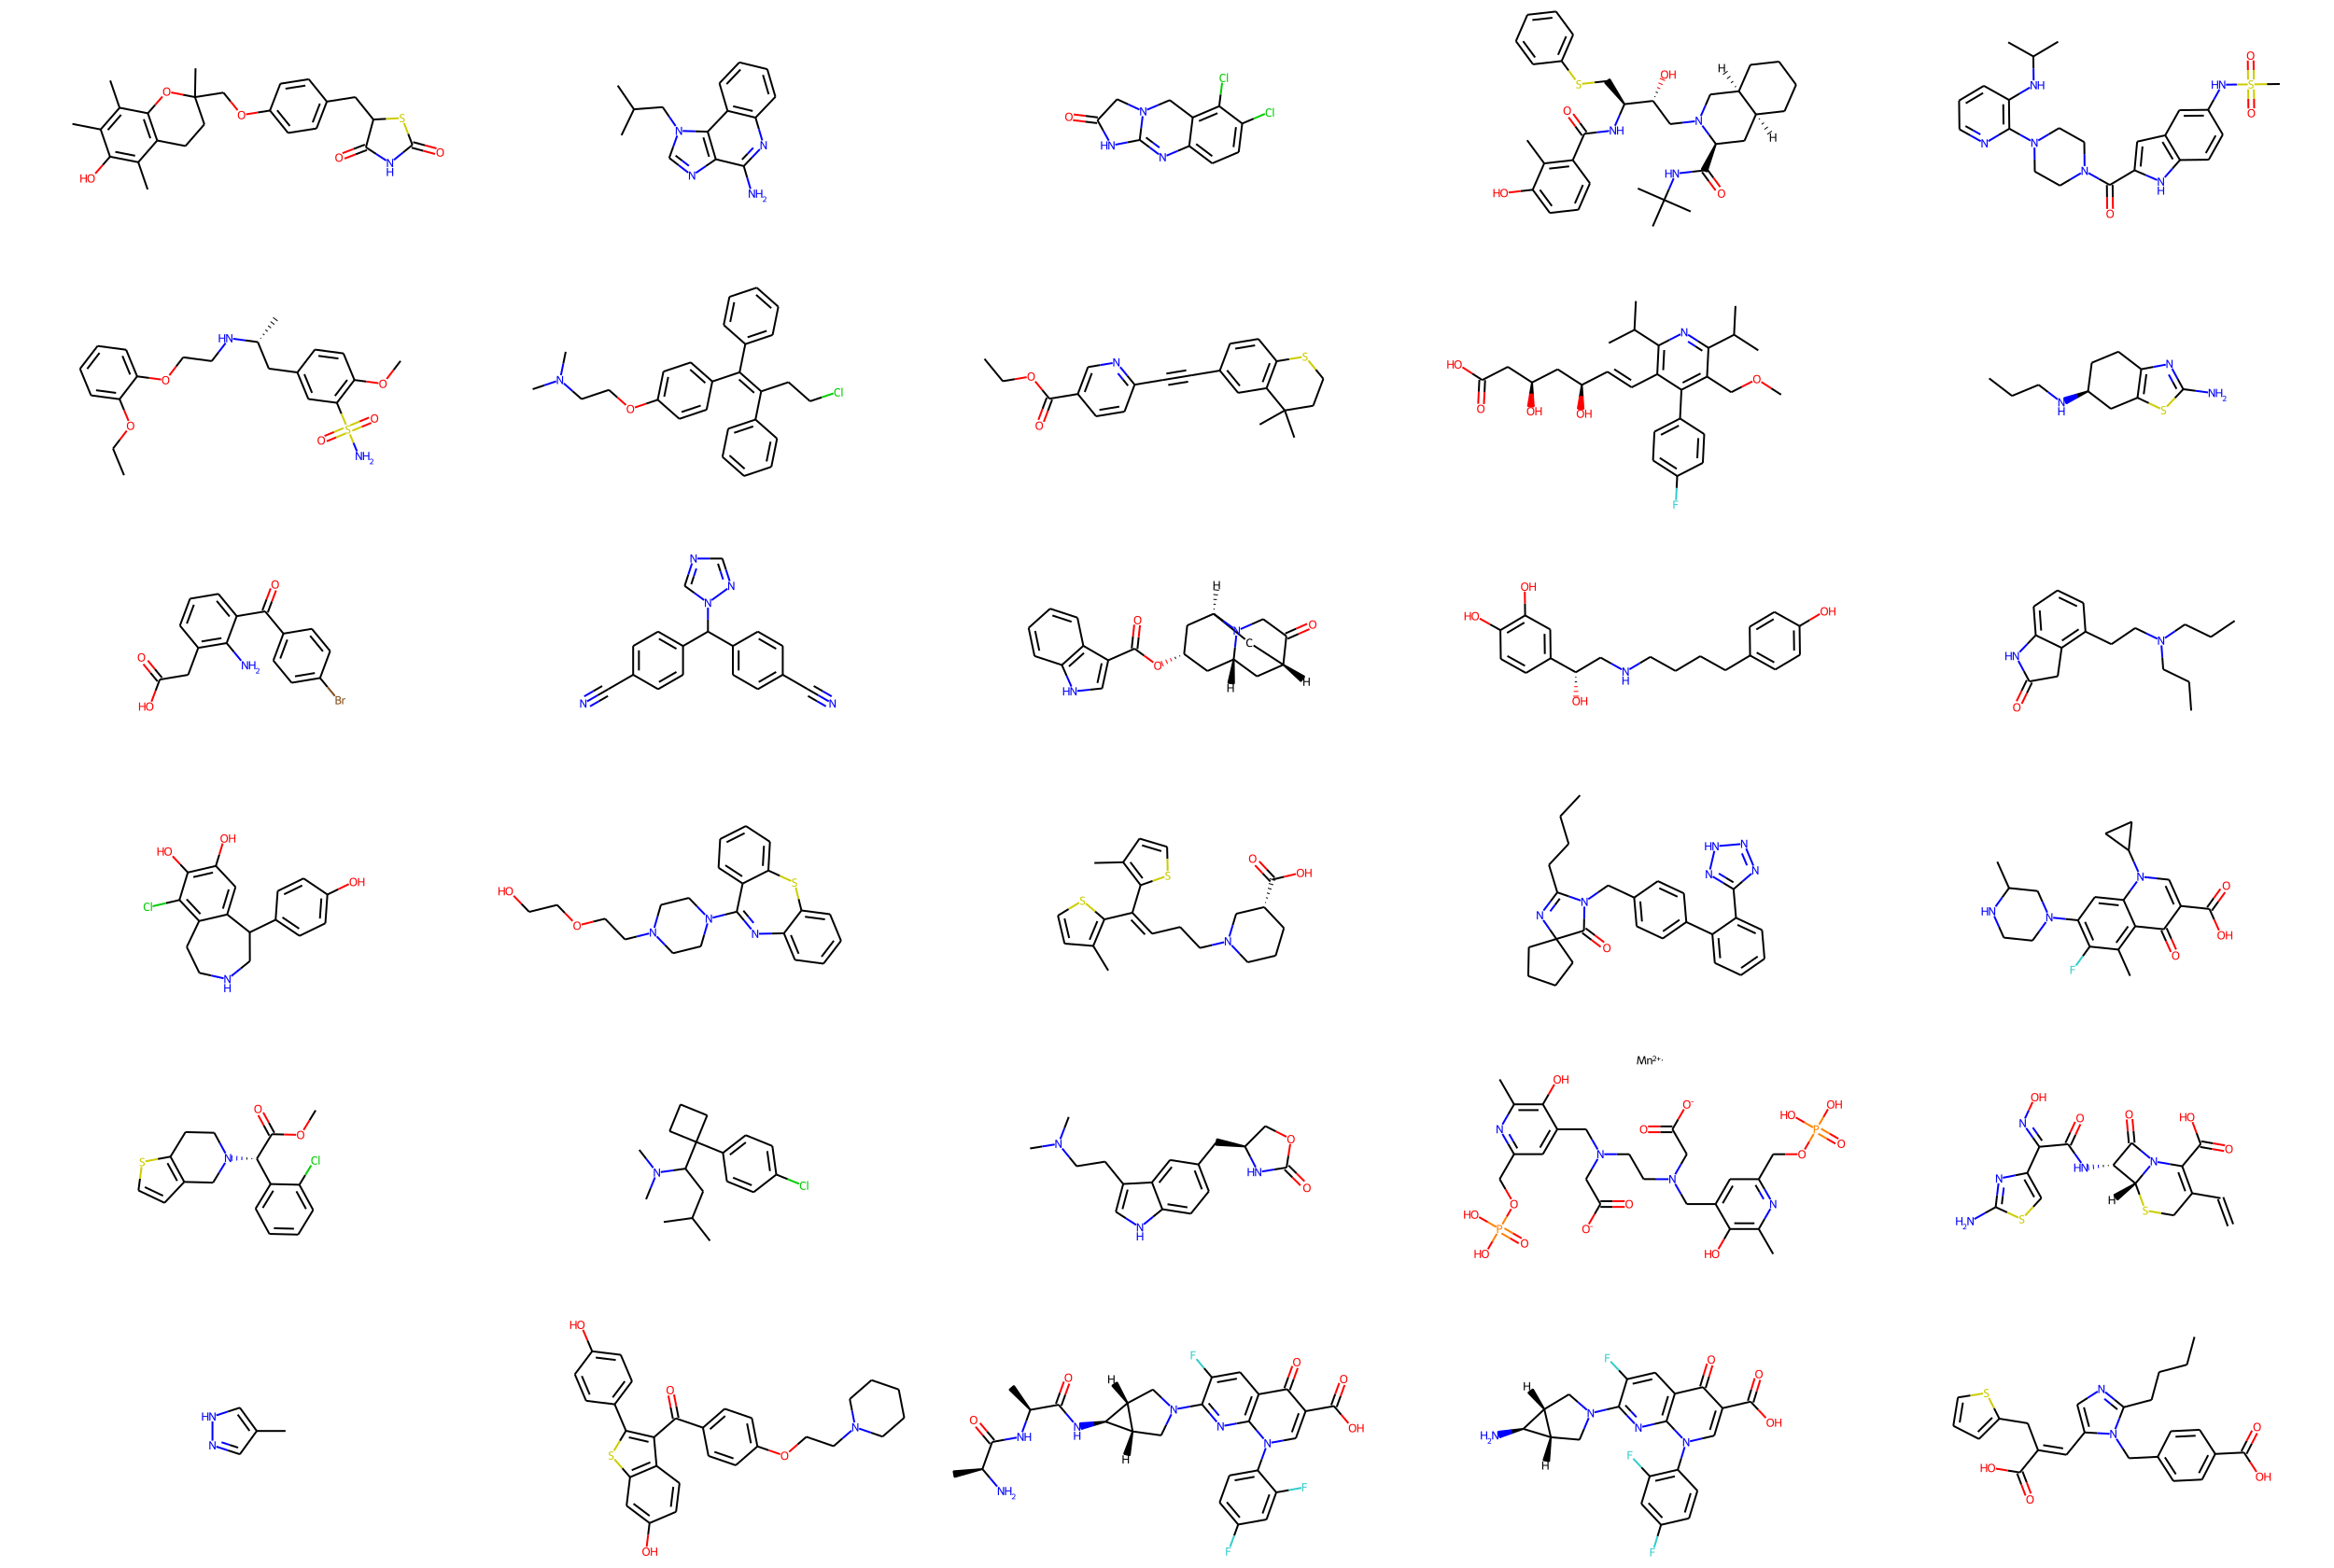

In [5]:
# Just taking a peek into drug structures
drugs_mol = [Chem.MolFromSmiles(drug) for drug in drugs_smiles]
# Drawing the first n structures
Draw.MolsToGridImage(drugs_mol, subImgSize=(500,280), molsPerRow=5, maxMols=30)

## Fixing non-readable SMILES

The problem is the following: some of the SMILES can't be *'kekulized'*. Turns out that this is totally chemistry related, as two different structures are yielded when we try to convert SMILES directly to mol. One of the solutions is to use the *CACTUS IDENTIFIER RESOLVER*. I did some previous tests and it forces the addition of hydrogen in a systematic way. This temporarily solves our problems.

### Functions to clean the rings:

In [6]:
# Solution to the SMILES not kekulized
# First step:
import requests
CACTUS_END = 'https://cactus.nci.nih.gov/chemical/structure/'
def smiles_from_cactus(SMILES) -> str:
    """
    Function to check if the SMILES are 'kekulizable' and use the CACTUS CADD Chemical Identifier Resolver 
    to retrieve back a proper convertable SMILES.
    """
    smiles_request = f'{CACTUS_END}{SMILES}/smiles'
    response = requests.get(smiles_request)
    converted_smiles = response.text
    
    return converted_smiles

A very important observation about the function to retrieve SMILES from Cactus Identifier Resolver: When working with SMILES strings that contain triple bonds represented by '#', it is important to note that they have to be URL-escaped as '%23'. For example, the SMILES string for ethyne should be specified as 
'C%23C' instead of 'C#C' when encoded as part of a URL. Additionally, when dealing with InChI, it is necessary 
to URL-escape question marks as %3F.*

In [7]:
# Approximately 10% of our SMILES are not ready to be counted or even convertable to mol, even after we converted using CIR
# We're gonna go with our second approach to our still problematic or DIRTY smiles
def inchi_backto_smiles(SMILES):
    CACTUS_END = 'https://cactus.nci.nih.gov/chemical/structure/'
    inch_request = f'{CACTUS_END}{SMILES}/stdinchi'
    response = requests.get(inch_request)
    inch = response.text

    smiles_request = f'{CACTUS_END}{inch}/smiles'
    response = requests.get(smiles_request)
    smiles_back = response.text
    return Chem.MolToSmiles(Chem.MolFromSmiles(smiles_back))

### First step:

In the first step we're going to separate the good from the bad! I used two lists one for the already ready-to-go SMILES, which can be standardized and onte for the 'dirty' SMILES, that needs more processing. Turns out this is a good approach, as we're going to see that the 'ready-to-go' makes the great majority of SMILES.

In [8]:
# We first create two lists 1) problematic smiles and clean SMILES
canon_smiles = []
dirty_smiles = []

# Then we check it if the ring_smile is problematic, if it is we try and trieve the smiles from Cactus;
for ring_smile in rings_on_smiles:
    if Chem.MolFromSmiles(ring_smile) is None:
        dirty_smiles.append(smiles_from_cactus(ring_smile))
    else:
        # The conversion to mol and then back to smiles is to make the smiles standard, the reason is depicted below
        canon_smiles.append(Chem.MolToSmiles(Chem.MolFromSmiles(ring_smile)))

RDKit ERROR: [15:04:04] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8 9 10 11 12
[15:04:04] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8 9 10 11 12
RDKit ERROR: [15:04:05] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[15:04:05] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
RDKit ERROR: [15:04:05] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[15:04:05] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
RDKit ERROR: [15:04:06] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[15:04:06] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit ERROR: [15:04:07] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[15:04:07] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
RDKit ERROR: [15:04:08] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[15:04:08] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit ERROR: [15:04:08] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[15:04:08] Can't kekulize mol.  Unkeku

 The conversion to mol and then back to smiles is to make the smiles standard, the reason is depicted below, from the [Getting Started with RDKit](https://www.rdkit.org/docs/GettingStartedInPython.html) page.

 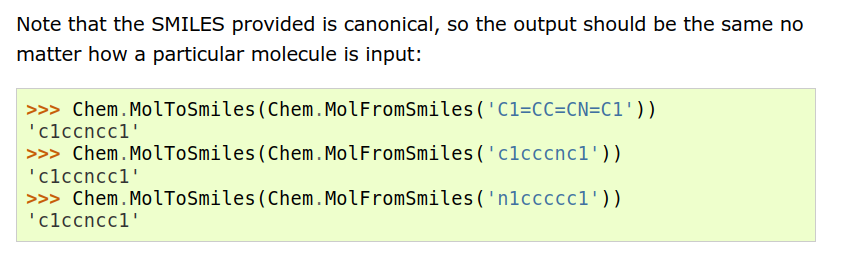

In [9]:
print(f'This is how many non-problematic SMILES we have got: {len(canon_smiles)}')
print(f"This is how many PROBLEMATIC SMILES we still have got: {len(dirty_smiles)}")
print(f"In total we have: {len(canon_smiles)+len(dirty_smiles)} ring system SMILES")
print(f"Basically we have {len(canon_smiles)/(len(canon_smiles)+len(dirty_smiles))*100:.2f}% already ready-to-be standardized SMILES")

This is how many non-problematic SMILES we have got: 1329
This is how many PROBLEMATIC SMILES we still have got: 115
In total we have: 1444 ring system SMILES
Basically we have 92.04% already ready-to-be standardized SMILES


### Second step:

So now in our second step we're going to try to convert the SMILES into InChI and then back to SMILES; Some structures cannot be converted and we append it into the garbage list, to throw it away;

In [10]:
smiles_from_inchi = []
garbage = []

for ring_smile in dirty_smiles:
    try:
        smiles_from_inchi.append(Chem.MolToSmiles(Chem.MolFromSmiles(inchi_backto_smiles(ring_smile))))
        # We convert to Mol and then back to SMILES as it makes the SMILES standardized;
    except:
        garbage.append(ring_smile)

RDKit ERROR: [15:06:28] Explicit valence for atom # 3 N, 5, is greater than permitted
[15:06:28] Explicit valence for atom # 3 N, 5, is greater than permitted
RDKit ERROR: [15:07:07] Explicit valence for atom # 5 N, 5, is greater than permitted
[15:07:07] Explicit valence for atom # 5 N, 5, is greater than permitted
RDKit ERROR: [15:07:20] SMILES Parse Error: syntax error while parsing: <h1>Page
[15:07:20] SMILES Parse Error: syntax error while parsing: <h1>Page
RDKit ERROR: [15:07:20] SMILES Parse Error: Failed parsing SMILES '<h1>Page' for input: '<h1>Page'
[15:07:20] SMILES Parse Error: Failed parsing SMILES '<h1>Page' for input: '<h1>Page'
RDKit ERROR: [15:07:51] SMILES Parse Error: syntax error while parsing: <h1>Page
RDKit ERROR: [15:07:51] SMILES Parse Error: Failed parsing SMILES '<h1>Page' for input: '<h1>Page'
[15:07:51] SMILES Parse Error: syntax error while parsing: <h1>Page
[15:07:51] SMILES Parse Error: Failed parsing SMILES '<h1>Page' for input: '<h1>Page'
RDKit ERROR: [

In [11]:
print(f"We've got {len(dirty_smiles)}, and after the cleaning we're left with {len(smiles_from_inchi)} which could be resolved and {len(garbage)} which could not")

We've got 115, and after the cleaning we're left with 106 which could be resolved and 9 which could not


In [12]:
# Merging both the lists
clean_smiles = canon_smiles + smiles_from_inchi
print(f"After merging the two lists, we have a total of {len(clean_smiles)/(len(canon_smiles)+len(dirty_smiles))*100:.2f}% of cleaning the initial dataset")

After merging the two lists, we have a total of 99.38% of cleaning the initial dataset


In [13]:
# Counting the SMILES appearances:
counter = {}
for ring_smile in clean_smiles:
    counter[ring_smile] = counter.get(ring_smile, 0) + 1

# Transforming it into a pandas object:
rings_df = pd.DataFrame.from_dict(counter, orient='index', columns=['n'])
rings_df = rings_df.reset_index()
rings_df.rename(columns={'index':'SMILES'}, inplace=True)

#  On descending order to ease the vizualization
rings_df = rings_df.sort_values(by='n', ascending=False)
rings_df = rings_df.reset_index(drop=True)
rings_df

,SMILES,n
0,c1ccccc1,478
1,c1ccncc1,78
2,C1CCNCC1,52
3,C1CCNC1,44
4,C1CNCCN1,42
...,...,...
257,c1ccc2c(c1)CCn1ccnc1C2,1
258,C1C[C@@H]2C[C@H]1[C@H]1CNC[C@@H]21,1
259,c1ncsn1,1
260,C1C[C@H]2C[C@@H]3OCC[C@H]3CCC[C@H]3CC[C@@H]4O[...,1


### Getting the name of each ring

In [14]:
CACTUS_END = 'https://cactus.nci.nih.gov/chemical/structure/'

def get_chemical_name(SMILES) -> str:
    """
    Function to retrieve the chemical name of a structure from SMILES
    """
    names_request = f'{CACTUS_END}{SMILES}/names'
    response = requests.get(names_request)
    first_name = response.text.split('\n')[0].lower()

    if '<h1>' in first_name:
        first_name = "chemical name not found"

    return first_name

In [15]:
rings_df['chemical_name'] = rings_df.SMILES.apply(get_chemical_name)
rings_df

,SMILES,n,chemical_name
0,c1ccccc1,478,benzene
1,c1ccncc1,78,pyridine
2,C1CCNCC1,52,piperidine
3,C1CCNC1,44,pyrrolidine
4,C1CNCCN1,42,piperazine
...,...,...,...
257,c1ccc2c(c1)CCn1ccnc1C2,1,"6,11-dihydro-5h-imidazo[1,2-c][3]benzazepine"
258,C1C[C@@H]2C[C@H]1[C@H]1CNC[C@@H]21,1,chemical name not found
259,c1ncsn1,1,"1,2,4-thiadiazole"
260,C1C[C@H]2C[C@@H]3OCC[C@H]3CCC[C@H]3CC[C@@H]4O[...,1,chemical name not found


### Saving the dataframe

In [16]:
rings_df.to_csv("../data/rings_frequency_lipinski.csv", index= False)

### Printing the first [n] structures
#### n = 30

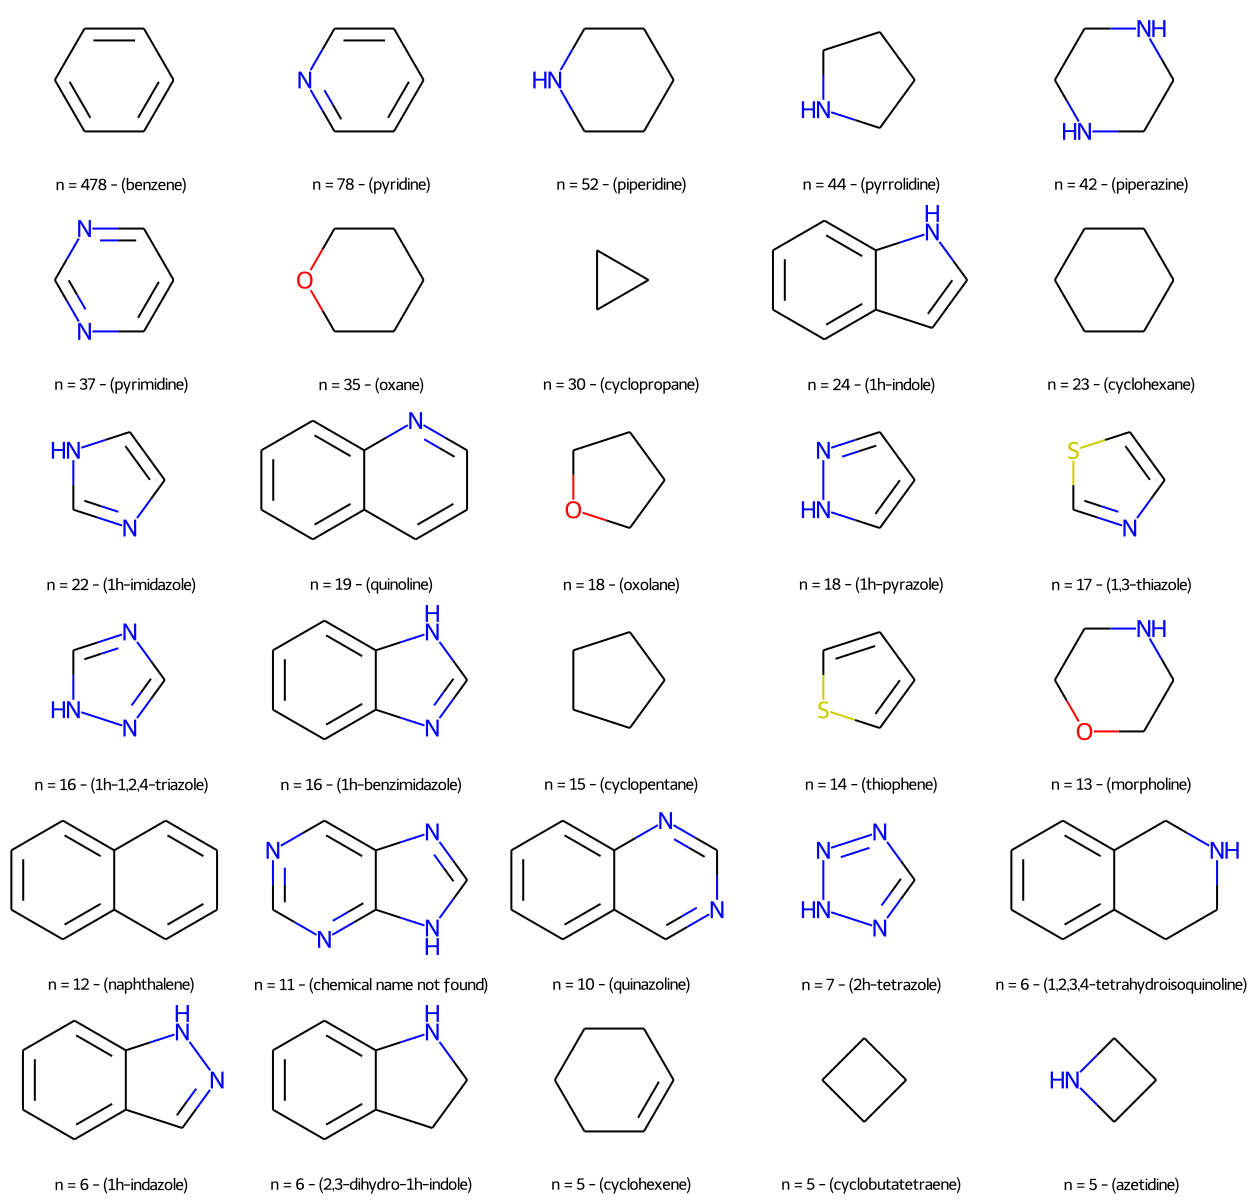

In [17]:
# n most frequent rings in the dataset
mol_rings = [Chem.MolFromSmiles(SMILES) for SMILES in list(rings_df.SMILES)[0:30]]
legends = [f'n = {str(number)} - ({str(name)})' for number, name in zip(list(rings_df.n),list(rings_df.chemical_name))]
d = Draw.MolsToGridImage(mol_rings, legends=legends, molsPerRow=5, maxMols=300, subImgSize=(250,200))
d

In [18]:
session_info.show()